#### Input data
Define standards absorbance and concentration

Define unknown absorbances

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd


input_fname = 'BCA_data_0.xlsx' 
#input_sheet = '020925'
input_sheet = '020625'
# comment out appropriate lines below when swapping dates

output_fname = f'BCA_output_{input_sheet}.xlsx'
output_sheet_lb = f'C_lb_{input_sheet}'
output_sheet_tb = f'C_tb_{input_sheet}'

# Read in the row data from Excel
df = pd.read_excel(input_fname, input_sheet)

# Show the first few rows of the data
print(df.head())

# loosely-bound (lb) and tightly-bound (tb) data
## 020625 ##
A_lb0  = df.iloc[4:6, 1:].values  # indexing excludes the last index
A_tb0  = df.iloc[7, 1:].values
## convert to numeric
A_lb   = np.vectorize(lambda x: pd.to_numeric(x, errors='coerce'))(A_lb0)  # 2D array
A_tb   = pd.to_numeric(A_tb0, errors='coerce')
## 020925 ##
#A_lb0  = df.iloc[4, 1:].values
#A_tb0  = df.iloc[6:8, 1:].values  # indexing excludes the last index
# convert to numeric
#A_lb   = pd.to_numeric(A_lb0, errors='coerce')
#A_tb   = np.vectorize(lambda x: pd.to_numeric(x, errors='coerce'))(A_tb0)  # 2D array


###   Do not change anything below here   ###

# standards
C_std0  = df.iloc[0, 1:].values  # (row 1, all columns but first)
A_std0  = df.iloc[1, 1:].values  

# convert to numerics
C_std  = pd.to_numeric(C_std0, errors='coerce') 
A_std  = pd.to_numeric(A_std0, errors='coerce')

# detection limit
lower_limit = 5  # ug/mL
upper_limit = 250

# flag to force line of best fit to intersect zero
force_zero = 1

      Unnamed: 0      F       E       D       C        B        A
0  Concentration   0.00   5.000  25.000  50.000  125.000  250.000
1     Absorbance   0.00   0.041   0.354   0.352    0.789    1.477
2            NaN    NaN     NaN     NaN     NaN      NaN      NaN
3          Names  40.00  20.000  14.000  10.000    7.000    5.000
4           A-LB   0.37   0.296   0.207   0.164    0.166    0.150


In [2]:
print(C_std)
print(A_std)
print(A_lb)
print(A_tb)

[  0.   5.  25.  50. 125. 250.]
[0.    0.041 0.354 0.352 0.789 1.477]
[[0.37  0.296 0.207 0.164 0.166 0.15 ]
 [0.174 0.086 0.063 0.217 0.068 0.08 ]]
[1.001 0.947 0.971 1.059 1.198 0.964]


#### Fit a 3rd degree polynomial to the data

3rd degree polynomial (Source: How to use a protein assay standard curve)

https://assets.thermofisher.com/TFS-Assets/LSG/Application-Notes/TR0057-Read-std-curves.pdf

We need a formula to solve for concentration given absorbance.

Formula Structure:  
x = A + By + Cy<sup>2</sup> + Dy<sup>3</sup>

where x is protein concentration and y is absorbance

I want the line to intersect the origin, and so I want the constant A to equal 0.  I can force this.  I expected that changing this would alter the R-squared value, but it is not.

Then, use the fit line to solve for the concentration of the unknown samples.

Coding Resources:

This example was useful in understanding polyfit: 
https://stackoverflow.com/questions/18767523/fitting-data-with-numpy

In [3]:
# fit the standards 
coefs = poly.polyfit(A_std, C_std, 3)  # 3rd deg polynomial

# This forces the fit line to intersect (0,0)
if force_zero == 1:
    coefs[0] = 0
    
# create line of best fit 
C_fit = poly.polyval(A_std, coefs)  # [ug/mL]
print('coefficients: ', coefs, '\n')

# function to determine concentration of unknown samples
def solve_conc(y):
    return poly.polyval(y, coefs)

# determine concentration of unknown samples [ug protein/mL buffer]
C_lb = solve_conc(A_lb)  # [ug/mL]
C_tb = solve_conc(A_tb)  # [ug/mL]
print('concentration[ug/mL]: ', C_lb)

coefficients:  [  0.          33.09235244 230.33881032 -93.98510496] 

concentration[ug/mL]:  [[39.01692601 27.53926024 15.88628091 11.20777541 11.41063107  9.82927637]
 [12.23669136  4.48974836  2.97553225 17.0670955   3.2858147   4.07343621]]


#### Solve for R-squared
This applies to the standard data 

This resource showed me how to calculate R-squared: 
https://www.askpython.com/python/coefficient-of-determination

In [4]:
# How good is the fit?
# Solve for the coefficient of determination (R-squared)
corr_matrix = np.corrcoef(C_std, C_fit)  # (actual, predict)
corr = corr_matrix[0,1]
R_sq = corr**2
print('R^2: ', R_sq)

R^2:  0.9930279794573174


#### Verify the samples are within the concentration range of the standards

Plot the standards against the unknown data 

Use concontration units for the standards (not in terms of VSS)

In [5]:
# check lower limit
if np.any(C_lb < lower_limit) == True:
    print('WARNING: Some LB concentrations are lower than the lower limit.')
    print(C_lb)
if np.any(C_tb < lower_limit) == True:
    print('WARNING: Some TB concentrations are lower than the lower limit.')
    print(C_tb)

# check upper limit
if np.any(C_lb > upper_limit) == True:
    print('WARNING: Some LB concentrations are highter than the upper limit.')
    print(C_lb)
if np.any(C_tb > upper_limit) == True:
    print('WARNING: Some TB concentrations are highter than the upper limit.')
    print(C_tb)

[[39.01692601 27.53926024 15.88628091 11.20777541 11.41063107  9.82927637]
 [12.23669136  4.48974836  2.97553225 17.0670955   3.2858147   4.07343621]]


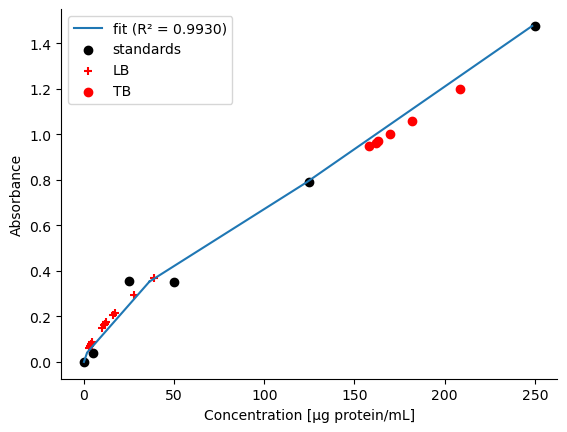

In [6]:
# plot line of best fit and standard data
plt.plot(C_fit, A_std, label = 'fit')       # line of best fit from standard data
plt.scatter(C_std, A_std, c='black', label = 'standard')     # standard data

# Plot unknown data
plt.scatter(C_lb, A_lb, c='red', marker='+', label = 'LB')  # loosely-bound
plt.scatter(C_tb, A_tb, c='red', marker='o', label = 'TB')  # tightly-bound

# axes labels
plt.xlabel("Concentration [\u03bcg protein/mL]")
plt.ylabel("Absorbance")
plt.legend(['fit (R\u00b2 = %.4f)' % R_sq,'standards','LB', 'TB']) 

# remove outer borderI
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'Std_curve_{input_sheet}.png')

#### Save concentrations

In [19]:
# reshape C_tb to be one row, not one column
if C_tb.shape == (6,):
    C_tb = C_tb.reshape(1, -1)
if C_lb.shape == (6,):
    C_lb = C_lb.reshape(1, -1)

# Convert 2D arrays to DataFrame and save to Excel
df_C_lb = pd.DataFrame(C_lb)
df_C_tb = pd.DataFrame(C_tb)

# Save to Excel file
with pd.ExcelWriter(output_fname) as writer:
    df_C_lb.to_excel(writer, sheet_name = output_sheet_lb)  
    df_C_tb.to_excel(writer, sheet_name = output_sheet_tb)


I take the two Excel output files and combine them into one file (BCA_output.xlsx).

Then, I load that into the next code, Plot_C, to plot the final results.